In [28]:
pip install "numpy>=1.16.5,<1.23.0"

Note: you may need to restart the kernel to use updated packages.


# Import Library

In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import img_to_array, load_img

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Atur lokasi dataset

In [2]:
# atur lokasi
dir_dataset = "/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256" # Mendefinisikan path dataset

# total semua data
train_dir = "/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Training"
val_dir = "/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Validation"

# ================= banyak data train ===========================
train_class = sorted(os.listdir(train_dir))
dict_train = {}

for class_name in train_class:
  class_dir = os.path.join(train_dir, class_name)
  val_count = len(os.listdir(class_dir))
  key = class_name
  value = val_count
  dict_train[key] = value

train_count = sum([len(files) for r, d, files in os.walk(train_dir)])

print (f'''
Banyak data train Early Blight                                  :  {dict_train["Early_Blight"]} data
Banyak data train Late Blight                                   :  {dict_train["Late_Blight"]} data
Banyak data train Healty                                        :  {dict_train["Healthy"]} data
                                          ---------
Total data Train                                                : {train_count} data''')

# ================= Banyak data Val ============================
val_class = sorted(os.listdir(val_dir))
dict_valid = {}

for class_name in val_class:
  class_dir = os.path.join(val_dir, class_name)
  val_count = len(os.listdir(class_dir))
  key = class_name
  value = val_count
  dict_valid[key] = value

val_count = sum([len(files) for r, d, files in os.walk(val_dir)])

print (f'''
Banyak data train Early Blight                                  :  {dict_valid["Early_Blight"]} data
Banyak data train Late Blight                                   :  {dict_valid["Late_Blight"]} data
Banyak data train Healty                                        :  {dict_valid["Healthy"]} data
                                          ---------
Total data Train                                                : {dict_valid} data''')

total_data = train_count + val_count
print (f'''
Total seluruh data                      : {total_data} data''')


Banyak data train Early Blight                                  :  1303 data
Banyak data train Late Blight                                   :  1132 data
Banyak data train Healty                                        :  816 data
                                          ---------
Total data Train                                                : 3251 data

Banyak data train Early Blight                                  :  163 data
Banyak data train Late Blight                                   :  151 data
Banyak data train Healty                                        :  102 data
                                          ---------
Total data Train                                                : {'Early_Blight': 163, 'Healthy': 102, 'Late_Blight': 151} data

Total seluruh data                      : 3667 data


# Visualisasi data

In [3]:
# menggabungkan total data dari validasi dan train seluruh kelas
dict_data = {}
for key in dict_train:
  dict_data[key] = dict_train.get(key, 0) + dict_valid.get(key, 0)

for key in dict_valid:
    if key not in dict_train:
        dict_data[key] = dict_valid[key]

# dict_data

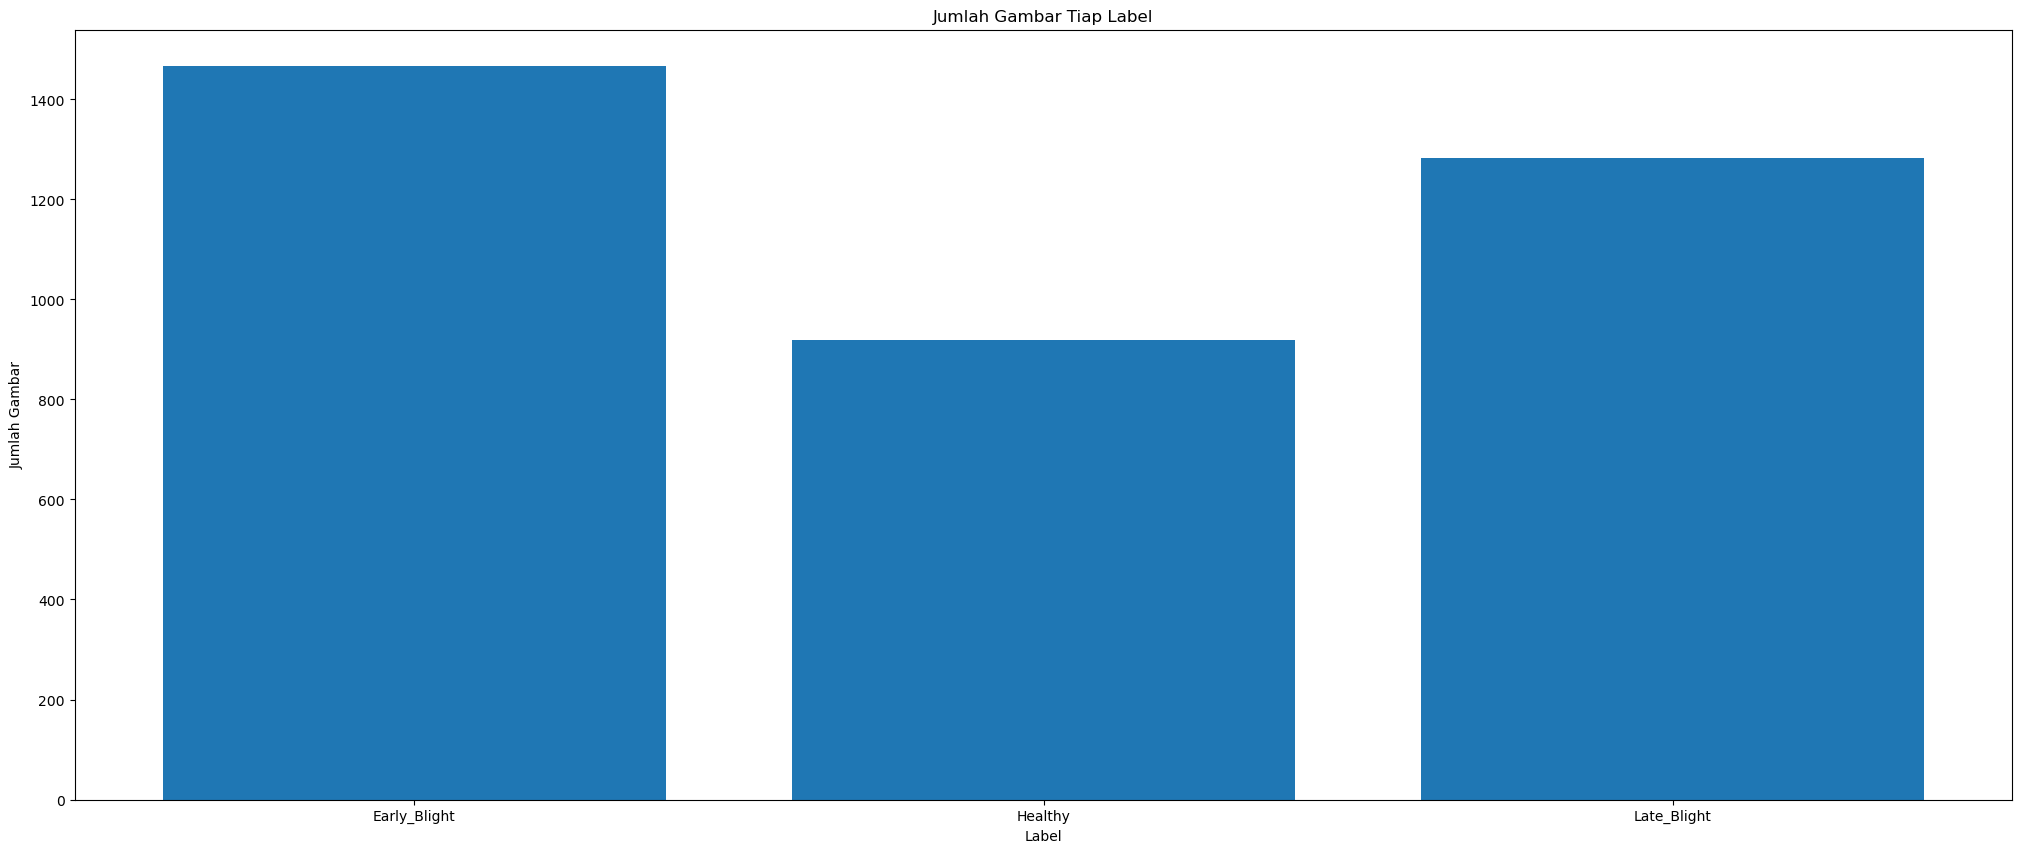

In [4]:
fig = plt.figure(figsize=(25, 10))
plt.bar(dict_data.keys(), dict_data.values());
plt.title("Jumlah Gambar Tiap Label");
plt.xlabel('Label');
plt.ylabel('Jumlah Gambar');

# Preprocessing

In [5]:
# split data 20% untuk validasi   
# Mengatur lebar dan tinggi gambar
img_width = 224
img_height = 224
channels = 3
batch_size = 16

Train_datagen = ImageDataGenerator(rescale=1./255)

Validation_datagen = ImageDataGenerator(rescale=1./255)

# Train dan Validation generator  dengan mode categorical
Train_generator = Train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width,img_height),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = batch_size,
    shuffle = True
)

Validation_generator = Validation_datagen.flow_from_directory(
    val_dir,
    target_size = (img_width,img_height),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = batch_size,
    shuffle = False
)

Found 3251 images belonging to 3 classes.
Found 416 images belonging to 3 classes.


# Modeling CNN

In [6]:
##### Pembuatan model
from keras import regularizers
# inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height,3))

# for layer in inception_model.layers:
#   layer.trainable = False

cnn_model = tf.keras.models.Sequential(
    [    #  inception_model,
     tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(img_width, img_height,3)),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Flatten(),
     # Droupout
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(128, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)),
     tf.keras.layers.Dense(3, activation='softmax')
    ]
)

In [7]:
# Penggunaan Optimizer 'Adam' dengan learning rate 0.00146
Optimizer = tf.keras.optimizers.Adam(1e-5)
cnn_model.compile(optimizer=Optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy']) 

In [8]:
# create callbacks
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs['accuracy'] >= 0.9 and logs['val_accuracy'] >= 0.8:
            print("\nReached 80% accuracy and testing accuracy so cancelling training!")
            self.model.stop_training = True

In [9]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 373248)            0         
                                                                 
 dropout (Dropout)           (None, 373248)            0

In [10]:
callbacks = myCallback()
history = cnn_model.fit(Train_generator,
                    validation_data = Validation_generator,
                    epochs = 60,
                    verbose = 1,
                    callbacks=callbacks)

Epoch 1/60
204/204 [==============================] - 35s 154ms/step - loss: 2.7203 - accuracy: 0.5152 - val_loss: 2.0154 - val_accuracy: 0.6490
Epoch 2/60
204/204 [==============================] - 12s 57ms/step - loss: 1.7386 - accuracy: 0.6460 - val_loss: 1.5052 - val_accuracy: 0.6755
Epoch 3/60
204/204 [==============================] - 12s 58ms/step - loss: 1.3955 - accuracy: 0.6912 - val_loss: 1.3062 - val_accuracy: 0.6947
Epoch 4/60
204/204 [==============================] - 12s 57ms/step - loss: 1.2292 - accuracy: 0.7099 - val_loss: 1.1778 - val_accuracy: 0.7260
Epoch 5/60
204/204 [==============================] - 12s 59ms/step - loss: 1.1264 - accuracy: 0.7232 - val_loss: 1.1302 - val_accuracy: 0.6875
Epoch 6/60
204/204 [==============================] - 12s 58ms/step - loss: 1.0585 - accuracy: 0.7336 - val_loss: 1.0906 - val_accuracy: 0.6538
Epoch 7/60
204/204 [==============================] - 12s 58ms/step - loss: 0.9806 - accuracy: 0.7579 - val_loss: 0.9968 - val_accuracy

# Cek precision, f1 score, recall

In [11]:
# Precission, F1 score, recall
import numpy as np
from sklearn.metrics import recall_score, f1_score, precision_score


val_preds = cnn_model.predict_generator(Validation_generator)
val_preds = np.argmax(val_preds, axis=-1)
val_true = Validation_generator.classes

# ==================== Precission
precision = precision_score(val_true, val_preds, average='weighted')
precision = round(float(precision), 2)

# ==================== Recall
recall = tf.keras.metrics.Recall()(val_true, val_preds)
recall = tf.reduce_mean(recall)
recall = round(float(recall), 2)

# ==================== F1 socre
f1 = f1_score(val_true, val_preds, average='weighted')
f1 = round(f1,2)

print(f'''
Hasil dari Precission, recall, dan F1 score sebagai berikut
--------------------------
Recall     : {recall} / {recall*100}%
--------------------------
Precission : {precision} / {precision*100}%
--------------------------
F1 score   : {f1} / {f1*100}%
--------------------------''')
# precision.dtype

/tmp/ipykernel_28/1376994368.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  val_preds = cnn_model.predict_generator(Validation_generator)



Hasil dari Precission, recall, dan F1 score sebagai berikut
--------------------------
Recall     : 0.9 / 90.0%
--------------------------
Precission : 0.83 / 83.0%
--------------------------
F1 score   : 0.83 / 83.0%
--------------------------


# grafik akurasi train dan val, loss train dan val

In [ ]:
# Membuat plot akurasi model VGG16
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model VGG16
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

# Test Model

In [46]:
Train_generator.class_indices

{'Early_Blight': 0, 'Healthy': 1, 'Late_Blight': 2}

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
# mengambil data acak 15
img_dir = "/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Testing/Early_Blight"
img_list = os.listdir(img_dir)
random_size = 25
img_sources = random.sample(img_list, random_size)

i = 1
total_high = []
for img_source in img_sources:
    img_path = os.path.join(img_dir, img_source)
    image_load = image.load_img(img_path, target_size=(img_width, img_height))
#     imgplot = plt.imshow(image_load)
    x = image.img_to_array(image_load)
    x = np.expand_dims(x, axis=0)
    probs = cnn_model.predict(x)


# img_source = "/kaggle/input/rice-leafs-disease-dataset/RiceLeafsDisease/validation/healthy/healthy_val (12).jpg"
# image_load = image.load_img(img_source, target_size = (img_width,img_height))
# imgplot = plt.imshow(image_load)
# x = image.img_to_array(image_load)
# x = np.expand_dims(x, axis=0)
# probs = cnn_model.predict(x)
    print (f'''iterasi ke - {i} : ''')
    # convert percent 
    probs = np.clip(probs,0,1)
    percent = probs * 100

    # print softmax probabilities
    high = np.argmax(probs)
    
    
    if high == 0:
        print ("Early Blight")
        print(f'''Akurasi : {np.round(percent[0,0],2)}''')
        total_high.append(high)
    elif high == 1:
        print("Healty")
        print(f'''Akurasi : {np.round(percent[0,1],2)}''')
        total_high.append(high)
    else:
        print("Late Blight")
        print(f'''Akurasi : {np.round(percent[0,2],2)}''')
        total_high.append(high)
    print("\n--------------------------------------------")
        
    i += 1

# print (total_high)

In [ ]:
# initial
dir_name = os.path.basename(img_dir)
dir_name_trainVal = os.path.basename(os.path.dirname(img_dir))
# hitung list
count_data0 = total_high.count(0)
count_data1 = total_high.count(1)
count_data2 = total_high.count(2)
count_data3 = total_high.count(3)
count_data4 = total_high.count(4)
count_data5 = total_high.count(5)

list_count = [count_data0,count_data1,count_data2,count_data3,count_data4,count_data5]
max_list_count = max(list_count)

# kondisi
if dir_name == 'Early_Blight':
    idx_name = count_data0
elif dir_name == 'Healthy':
    idx_name = count_data1
else:
    idx_name = count_data2
    

print(f'''\n*********************************************************************
Early_Blight           : {count_data0} data
Healthy                : {count_data1} data
Late_Blight            : {count_data2} data

Total data test        : {idx_name}/{random_size} data {dir_name} {dir_name_trainVal}

''')

In [12]:
model = cnn_model.save('cnn_model_potato.h5')

In [48]:
model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
cnn_model.save('model.h5')

In [57]:
import requests

# URL unduhan file H5
url = 'https://www.kaggle.com/code/muhamadnizam7/potato/edit/run/131235235'

# Lokasi penyimpanan lokal
local_path = '/kaggle/working/model.h5'

# Buat objek permintaan HTTP
response = requests.get(url, stream=True)

# Buat variabel untuk menyimpan status pembatalan
cancel_flag = True

try:
    # Menghitung ukuran file
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # Ukuran blok unduhan

    # Menyimpan file secara bertahap
    with open(local_path, 'wb') as file:
        for data in response.iter_content(block_size):
            # Cek status pembatalan
            if cancel_flag:
                print("Unduhan dibatalkan.")
                break

            # Menulis data ke file
            file.write(data)

except KeyboardInterrupt:
    # Tangkap KeyboardInterrupt (misalnya jika Anda menekan tombol Ctrl+C)
    print("Unduhan dibatalkan melalui KeyboardInterrupt.")

finally:
    # Tutup koneksi
    response.close()

# Menghapus file yang sebagian terunduh jika pembatalan dilakukan
if cancel_flag:
    os.remove(local_path)

print("Unduhan selesai!")


Unduhan dibatalkan.
Unduhan selesai!


In [54]:
from tqdm import tqdm
import requests

# URL unduhan file H5
url = 'https://www.kaggle.com/code/muhamadnizam7/potato/edit/run/131235235'

# Lokasi penyimpanan lokal
local_path = '/kaggle/working/cnn_model_potato.h5'

# Unduh file H5
response = requests.get(url, stream=True)

# Menghitung ukuran file
total_size = int(response.headers.get('content-length', 0))

# Menampilkan progress bar
progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)

# Menyimpan file secara bertahap
with open(local_path, 'wb') as file:
    for data in response.iter_content(total_size):
        # Menulis data ke file
        file.write(data)
        
        # Mengupdate progress bar
        progress_bar.update(len(data))

# Menutup progress bar
progress_bar.close()

print("Unduhan selesai!")


0.00iB [00:00, ?iB/s]

KeyboardInterrupt: 